# Simulations naïves de files d'attentes - Corrigé

Ce TP vous invite à explorer les files d'attentes à travers des simulations (souvent naïves) de celles-ci. L'étude des systèmes d'attente ne peut se contenter d'un travail d'analyse théorique. Ces analyses sont souvent non disponibles et leur production nécessitent un savoir-faire mathématique expert. La simulation dans ce contexte permet d'apporter un premier regard sur les phénomènes à l'observation, même si elles n'apporte pas de réponses définitives elles sont souvent suffisantes pour faire un choix en première approximation. À minimna une simulation permet une meilleure qualification des variables en jeux lors d'une potentielle mise à contribution d'une équipe spécialisée. 

-----------------------

## Générer de l'aléatoire

Simuler une file d'attente sous-entend simuler un phénomène aléatoire. Pour pouvoir aborder sereinement cette simulation, on s'autorise à utiliser les générateurs aléatoires à disposition dans `numpy`. De toute manière, vous savez déjà construire un générateur aléatoire à partir d'une loi uniforme, *n'est-ce pas?*

In [5]:
import numpy as np
import pandas as pd

Pour référence, on revient rapidement sur la simulation d'une variable aléatoire suivant une loi disponibles dans `numpy`. Il s'agit en premier lieu d'initialiser un générateur aléatoire, afin de garantir la reproductibilité des résultats puis de faire appel avec ce générateur aux différentes lois qu'on souhaite utiliser. Dans le cas markoviens, on sera limités aux lois exponentielles.

In [6]:
?? np.random.default_rng

Signature:       np.random.default_rng(seed=None)
Call signature:  np.random.default_rng(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction default_rng at 0x104f39cb0>
Docstring:     
default_rng(seed=None)
Construct a new Generator with the default BitGenerator (PCG64).

    Parameters
    ----------
    seed : {None, int, array_like[ints], SeedSequence, BitGenerator, Generator}, optional
        A seed to initialize the `BitGenerator`. If None, then fresh,
        unpredictable entropy will be pulled from the OS. If an ``int`` or
        ``array_like[ints]`` is passed, then all values must be non-negative and will be
        passed to `SeedSequence` to derive the initial `BitGenerator` state. One may also
        pass in a `SeedSequence` instance.
        Additionally, when passed a `BitGenerator`, it will be wrapped by
        `Generator`. If passed a `Generator`, it will be returned unaltered.

    Returns
    -------
    Generator
        The in

In [7]:
rng = np.random.default_rng(seed=42)

In [8]:
l = 2.

In [9]:
rng.exponential(1/l, 10)

array([1.2021043 , 1.16809483, 1.1923805 , 0.13989714, 0.0432187 ,
       0.72633026, 0.70498035, 1.56214798, 0.0396471 , 0.52328042])

Attention ici au fait que le premier paramètre de `rng.exponential` correspond à $1/\lambda$ et non à $\lambda$ dans le cours. Pour plus d'information vous êtes invités à consulter l'aide : `? rng.exponential`.

------------

## Modèle de travail

Afin de garantir une certaine généricité de fonctionnement, nous allons encoder le résultats d'une simulation dans un `dataframe` qui permette des post-traitements statiques sur les données d'une simulation. Cela permet également de stocker le résultat d'une simulation pour consultations ultérieures notamment si l'on souhaite faire des comparatifs entre différents choix de simulations ou de paramètrage. 

On va pour la suite charger la bibliothèque `pandas` qui permet de manipuler et stocker facilement des données tabulaires.

In [10]:
import pandas as pd

On qualifie **d'Agent** une notion qui correspond à celle de client
dans le folklore d'une file d'attente au guichet. Il est défini par
les attributs suivants

- `id` : son identifiant, un `int`.
- `t_arval_queue` : temps d'arrivée dans le système d'attente, `float`.
- `t_arval_srv` : temps d'accès à un serveur, `float`.
- `t_depart_sys` : temps de départ du système, `float`.

Dans l'implémentation qu'on propose chaque agent correspond aux
premières colonnes d'une ligne dans un dataframe, nommé `tops`. Les
colonnes concernées seront respectivement nommées
`t_arval_queue`, `t_arval_srv` et `t_depart_sys`. L'attribut `id` correspond à une indexation sur les lignes.

Les éléments décrits de `tops` correspondent aux tops d'un chronomètres en observation d'une file d'attente. On se laisse le droit, même si cela n'est pas très orthodoxe, de rajouter une information d'un autre ordre dans les colonnes de `tops`.

In [11]:
tops = pd.DataFrame(rng.uniform(.1, size=(10, 3)), 
                    columns = ['t_arval_queue', 't_arval_srv', 't_depart_sys'])

In [12]:
tops

,t_arval_queue,t_arval_srv,t_depart_sys
0,0.433718,0.934088,0.679479
1,0.840485,0.499073,0.304515
2,0.599126,0.157436,0.844868
3,0.668498,0.782279,0.419073
4,0.973628,0.903809,0.800545
5,0.275175,0.520049,0.139423
6,0.238861,0.714744,0.770286
7,0.970759,0.393243,0.433414
8,0.522600,0.270524,0.216929
9,0.528134,0.304218,0.702833


Le code précédent ne vise qu'à vous fixer la forme de `tops`. Il devrait être clair pour vous que le remplissage de `tops` dans le cadre de la simulation d'une file d'attente ne sera pas effectuer de cette façon. 

-------

# Simuler une file M/M/1

Il est bien entendu illusoire de souhaiter simuler une file M/M/1 qui s'exécute infiniment, il s'agit ici d'avoir une file pour laquelle aucun refus ne peut avoir lieu indépendamment des congestions qu'elle peut subir. Le nombre d'agents intervenants dans la simulation ne sont dans ce contexte qu'un échantillon de la population infinie considérée.

La classe qui suit, cherche à standardiser la façon avec laquelle on souhaite étudier / formaliser nos différentes simulation de files d'attentes

In [108]:
class mm1():
    """
    A class representing an mm1 queue. 

    Attributes :

        lamda (float)   : parameter of exponential law corresponding to interarrival times.
        mu (float)      : parameter of exponential law corresponding to service times.
        gen (np.random) : a random generator
        test_z (int)    : test size
        tops            : dataframe containing queue and service arrival times, and departure times for each agent.
    """
    
    
    def __init__(self, lamda, mu, gen, test_z=100) :
        """
        Initializes a new instance of the class mm1.
        
        Args :
            lamda  : parameter of exponential law corresponding to interarrival times.
            mu     : parameter of exponential law corresponding to service times.
            gen    : a random generator
            test_z : test size. 
        """
        
        #Initializing metadata
        self.lamda = lamda
        self.mu = mu
        self.gen = gen
        self.test_z = test_z
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((self.test_z, 3),dtype=object), columns=column_names)
        
    def run(self):
        """
        Simulates the mm1 queuing system

        Modifies the attribute tops following a simulation of mm1 queue respecting interarrival and 
        outgoing intensities given by corresponding attributes. Besides filling in queue arrival times, 
        service arrival times and departure times for each agent, it adds columns to tops corresponding 
        to sojourn time (t_sojourn), waiting time (t_waiting) and service time (t_service) of each agent.
        """
        #Easing naming
        tops = self.tops
        gen = self.gen
        lamda = self.lamda
        test_z = self.test_z
        
        #initializing queue interarrival distribution
        tops.loc[0, 't_arval_queue'] = gen.exponential(1./lamda)
        
        for agent_ix in range(1, test_z) :
            tops.loc[agent_ix, 't_arval_queue'] = tops.loc[agent_ix - 1, 't_arval_queue'] + gen.exponential(1./lamda)
        # Agent indexes order agents by their arrival times from first to last.


        #Computing service arrival times and system departure times
        tops.loc[0, 't_arval_srv'] = tops.loc[0, 't_arval_queue']
        tops.loc[0, 't_depart_sys'] = tops.loc[0, 't_arval_srv'] + gen.exponential(1./mu)
        for agent_ix in range(1, test_z):
            
            if tops.loc[agent_ix, 't_arval_queue'] > tops.loc[agent_ix - 1, 't_depart_sys'] :
                #Agent arrives in arrival queue and finds an empty server
                tops.loc[agent_ix, 't_arval_srv'] = tops.loc[agent_ix, 't_arval_queue']                          
            else: 
                #Agent arrives in arrival queue and finds full server
                tops.loc[agent_ix, 't_arval_srv'] = tops.loc[agent_ix - 1, 't_depart_sys']

            #Updating system departure time for agent.
            tops.loc[agent_ix, 't_depart_sys'] = tops.loc[agent_ix, 't_arval_srv'] + gen.exponential(1./mu)
                       
        #Enhancing tops to containing agent time laps information       
        tops['t_sojourn'] = tops['t_depart_sys'] - tops['t_arval_queue']
        tops['t_waiting'] = tops['t_arval_srv'] - tops['t_arval_queue']
        tops['t_service'] = tops['t_depart_sys'] - tops['t_arval_srv']    
    
    def compute_counts(self, nb_tops):
        """
        Computes number of agents in system at all given times.

        Args :
            nb_tops : total number of tops we're considering.

        Returns :
            A dataframe indexed by nb_tops time laps all along total queue simulation time, 
            its three columns contain number of agents in system (ag_in_sys), in arrival queue (ag_in_queue) and
            in service (ag_in_service).
        """                
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Initializing time tops dataframe
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), nb_tops)
        counts = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)

        #Computing number of agents in system at each given time t
        for t in counts.index:
            counts.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            counts.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            counts.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()

        return counts
    
    def compute_stats(self):
        """
        Computes statistics of a current simulation of queue.

        Returns:
            A dataframe indexed by standard statistics of interest mean sojourn time (mean_sojourn_time), 
            mean waiting time (mean_waiting_time) and mean service time (mean_service_time).
        """
        #Easing naming
        tops = self.tops
        
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time']
        
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        #Computing standard queuing system statistics.
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (self.test_z)
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (self.test_z)
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (self.test_z)
        
        return stats

1. **Implémenter les fonctions laissées dans le code.**

2. **Simuler le comportement d'une file mm1 avec les paramètres de votre choix. On note `mm1_counts` et `mm1_stats` les variables qui stockent les retours des fonctions `counts` et `stats` pour une exécution de votre choix de `mm1`. Vous pourrez représenter graphiquement les résultats de vos tests à l'aide du code ci-dessous**

In [109]:
lamda = 5.
mu = 10.
gen = rng
size = 100

In [110]:
mm1_queue = mm1(lamda, mu, gen, size)

In [111]:
mm1_queue.run()

In [112]:
mm1_counts = mm1_queue.compute_counts(2*size)

In [113]:
mm1_stats = mm1_queue.compute_stats()

In [114]:
mm1_stats

,run value
mean_sojourn_time,0.213456
mean_waiting_time,0.111104
mean_service_time,0.102352


In [115]:
import matplotlib.pyplot as plt

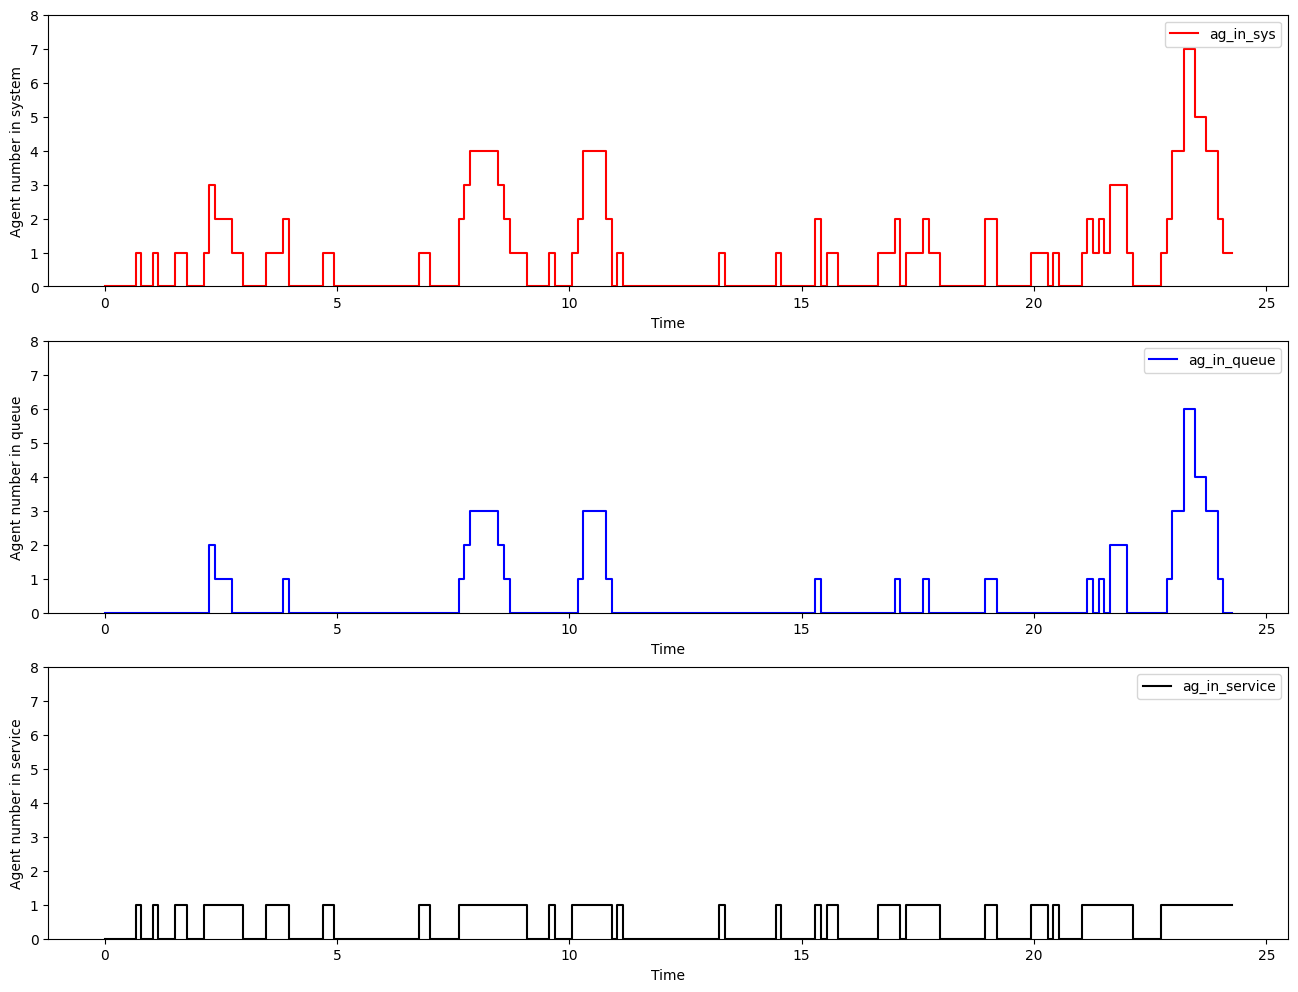

In [116]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_counts.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_counts['ag_in_sys']+1)])
    

3. **Comparer les résultats que vous obtenez à l'aide de votre simulateur aux résultats théorques attentdus.**

Le temps de séjour moyen devrait être du même ordre de grandeur que $\frac{1}{\mu - \lambda}$. Avec quelques simulations on constate qu'on est du même ordre de grandeur que cette valeur mais ce n'est pas tout bonnement une égalité. 

Afin de pouvoir statuer il s'agit d'effectuer suffisamment de simulation et de regarder les moyennes des temps de séjour des simulations à effectuer sur des échantillons de populations suffisamments grands.

-----------

# Le cas d'une file M/M/1/K

1. Quels sont les comportement qu'on souhaite retrouver dans le cas des files M/M/1/K qui sont exclus du cas M/M/1 précédents ?

Dans une file d'attente finie, on s'attend à retrouver une information sur la saturation et le refus d'accès au système à l'entrée.

2. Adapter le code `mm1` précédent au cas d'une file d'attente `mm1k`. 

In [117]:
class mm1k():
    """
    A class representing an mm1k queue. 

    Attributes :

        lamda (float)   : parameter of exponential law corresponding to interarrival times.
        mu (float)      : parameter of exponential law corresponding to service times.
        gen (np.random) : a random generator
        queue_z (int)   : size of arrival queue 
        test_z (int)    : test size
        tops            : dataframe containing queue and service arrival times, and departure times for each agent.
    """
    
    
    def __init__(self, lamda, mu, gen, queue_z=None, test_z=100) :
        """
        Initializes a new instance of the class mm1k.
        
        Args :
            lamda  : parameter of exponential law corresponding to interarrival times.
            mu     : parameter of exponential law corresponding to service times.
            gen    : a random generator
            queue_z : size of arrival queue
            test_z : test size. 
        """
        
        #Initializing metadata
        self.lamda = lamda
        self.mu = mu
        self.gen = gen
        self.queue_z = queue_z
        self.test_z = test_z
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((self.test_z, 3),dtype=object), columns=column_names)
        
    def run(self):
        """
        Simulates the mm1 queuing system

        Modifies the attribute tops following a simulation of mm1 queue respecting interarrival and 
        outgoing intensities given by corresponding attributes. Besides filling in queue arrival times, 
        service arrival times and departure times for each agent, it adds columns to tops corresponding 
        to sojourn time (t_sojourn), waiting time (t_waiting) and service time (t_service) of each agent.
        """
        #Easing naming
        tops = self.tops
        gen = self.gen
        lamda = self.lamda
        queue_z = self.queue_z
        test_z = self.test_z
        
        #initializing queue interarrival distribution
        tops.loc[0, 't_arval_queue'] = gen.exponential(1./lamda)
        
        for agent_ix in range(1, test_z) :
            tops.loc[agent_ix, 't_arval_queue'] = tops.loc[agent_ix - 1, 't_arval_queue'] + gen.exponential(1./lamda)
        # Agent indexes order agents by their arrival times from first to last.


        # Computing service arrival times and system departure times
        tops.loc[0, 't_arval_srv'] = tops.loc[0, 't_arval_queue']
        tops.loc[0, 't_depart_sys'] = tops.loc[0, 't_arval_srv'] + gen.exponential(1./mu)

        # Initialize index ranges for agents granted access to queuing system
        granted_ix = [0]

        current_ix = 1
        while current_ix < test_z :

            in_system = (tops.loc[0:current_ix - 1, 't_depart_sys'] > tops.loc[current_ix, 't_arval_queue']).sum()

            if queue_z is not None and in_system > queue_z :
                # Queuing system is saturated

                # Choice is made to fill dataframe with negative integers
                tops.loc[current_ix, 't_depart_sys'] = -1
                tops.loc[current_ix, 't_arval_srv'] = -1
                
                current_ix = current_ix + 1

                # Skip treatment of current_ix case
                continue

            previously_granted_ix = granted_ix[-1]
            
            if tops.loc[current_ix, 't_arval_queue'] > tops.loc[previously_granted_ix, 't_depart_sys'] :
                #Agent arrives in arrival queue and finds an empty server
                tops.loc[current_ix, 't_arval_srv'] = tops.loc[current_ix, 't_arval_queue']                          
            else: 
                #Agent arrives in arrival queue and finds full server
                tops.loc[current_ix, 't_arval_srv'] = tops.loc[previously_granted_ix, 't_depart_sys']

            #Updating system departure time for agent.
            tops.loc[current_ix, 't_depart_sys'] = tops.loc[current_ix, 't_arval_srv'] + gen.exponential(1./mu)

            granted_ix.append(current_ix)
            current_ix = current_ix + 1
                               
        #Enhancing tops to containing agent time laps information               
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def compute_counts(self, nb_tops):
        """
        Computes number of agents in system at all given times.

        Args :
            nb_tops : total number of tops we're considering.

        Returns :
            A dataframe indexed by nb_tops time laps all along total queue simulation time, 
            its three columns contain number of agents in system (ag_in_sys), in arrival queue (ag_in_queue) and
            in service (ag_in_service).
        """                
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Initializing time tops dataframe
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), nb_tops)
        counts = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)

        #Computing number of agents in system at each given time t
        for t in counts.index:
            counts.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            counts.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            counts.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()

        return counts
    
    def compute_stats(self):
        """
        Computes statistics of a current simulation of queue.

        Returns:
            A dataframe indexed by standard statistics of interest mean sojourn time (mean_sojourn_time), 
            mean waiting time (mean_waiting_time) and mean service time (mean_service_time).
        """
        #Easing naming
        tops = self.tops
        test_z = self.test_z
        
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time',
                     'waiting_proportion', 'blocked_proportion']
        
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        #Computing standard queuing system statistics.
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z
        
        return stats

In [118]:
lamda = 10.
mu = 30.
gen = rng
queue_size = 2
size = 100

In [119]:
mm1k_queue = mm1k(lamda, mu, gen, queue_size, size)

In [120]:
mm1k_queue.run()

In [121]:
mm1k_counts = mm1k_queue.compute_counts(2*size)

In [122]:
mm1k_stats = mm1k_queue.compute_stats()

In [123]:
mm1k_stats

,run value
mean_sojourn_time,0.042989
mean_waiting_time,0.012232
mean_service_time,0.030757
waiting_proportion,0.236559
blocked_proportion,0.07


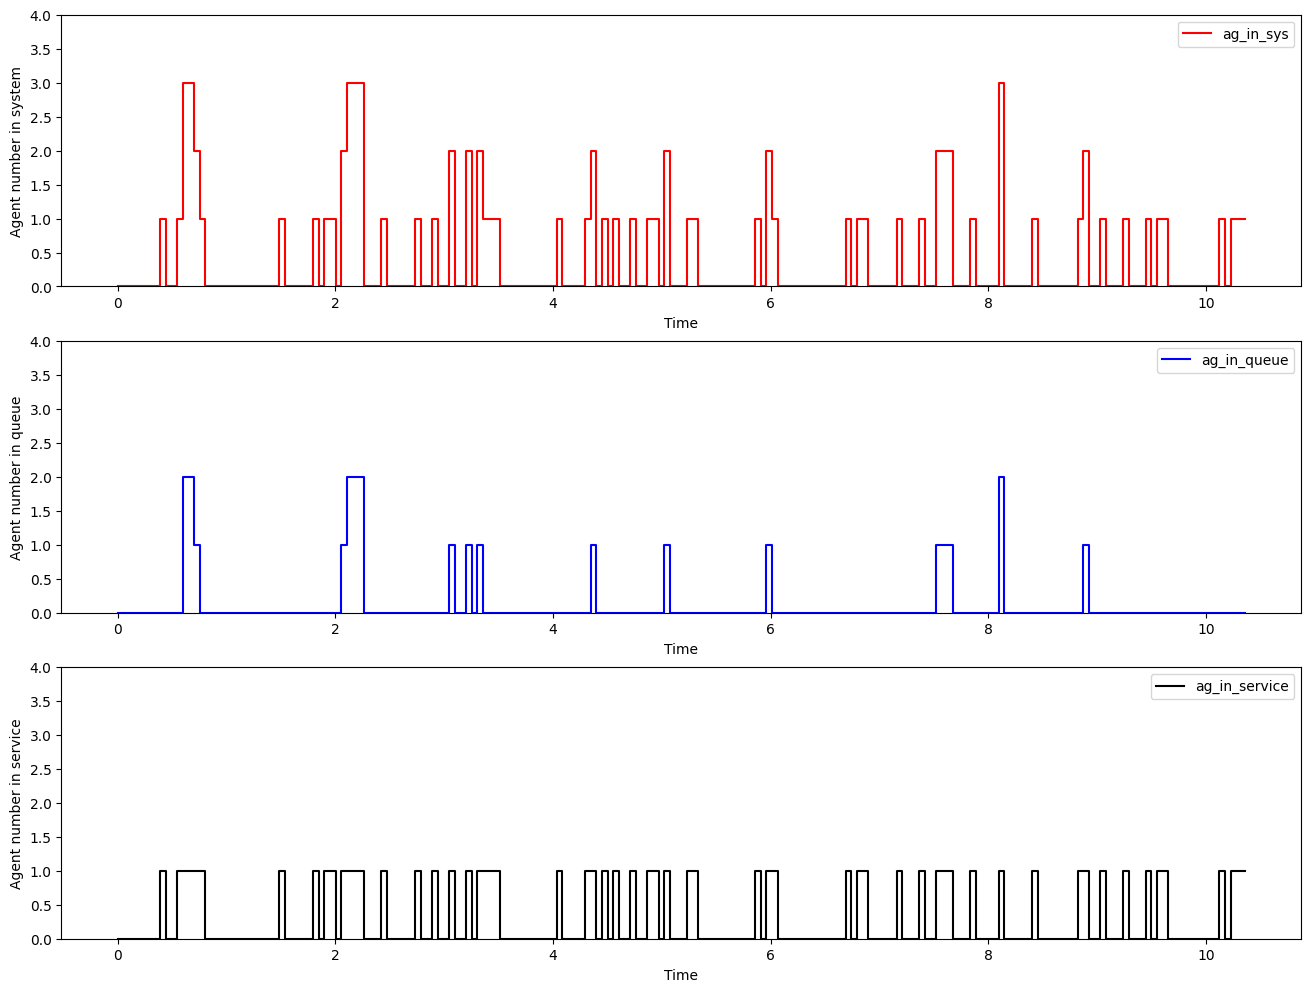

In [124]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1k_counts.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1k_counts['ag_in_sys']+1)])

3. Comparer ce que vous obtenez aux résultats théoriques.

Le temps de séjour moyen théorique dès que $\lambda \neq \rho$ est donné par :

In [125]:
E_T = (1/mu) / (1 - (lamda / mu)) 
E_T

0.049999999999999996

Pour vérifier la cohérence de ce résultat théorique en rapport à des conditions de simulation, il faut effectuer un travail de consolidation à travers une série de simulation, et des tests statistiques sur la distribution des moyennes de séjour des données empiriques.

4. Étuder l'impact de différentes politiques de priorisation sur les statistiques de comportement d'une file d'attente M/M/1/K

La réponse à cette question passe par le fait d'implémenter un modèle qui permette de qualifier la politique de priorisation. Un code est mis à votre disposition en fin de ce notebook. Il vous revient de le faire évoluer.

-------

# Files d'attentes déterministes

1. Simuler une file d'attente déterministe de type D/D/1/K.

In [207]:
class dd1k():
    """
    A class representing an dd1k queue. 

    Attributes :

        arval_freq (float)   : frequency of arrivals at queue ; an agent arrives every arval_freq tops.
        service_time (float) : time needed to treat an agent by server.
        queue_z (int)   : size of arrival queue 
        test_z (int)    : test size
        tops            : dataframe containing queue and service arrival times, and departure times for each agent.
    """
    
    
    def __init__(self, arval_freq, service_time, queue_z=None, test_z=100) :
        """
        Initializes a new instance of the class dd1k.
        
        Args :
            arval_freq (float)   : frequency of arrivals at queue ; an agent arrives every arval_freq tops.
            service_time (float) : time needed to treat an agent by server.
            queue_z : size of arrival queue
            test_z : test size. 
        """
        
        #Initializing metadata
        self.arval_freq = arval_freq
        self.service_time = service_time
        self.queue_z = queue_z
        self.test_z = test_z
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_z, 3),dtype=object), columns=column_names)
        
    def run(self):
        """
        Simulates the mm1 queuing system

        Modifies the attribute tops following a simulation of mm1 queue respecting interarrival and 
        outgoing intensities given by corresponding attributes. Besides filling in queue arrival times, 
        service arrival times and departure times for each agent, it adds columns to tops corresponding 
        to sojourn time (t_sojourn), waiting time (t_waiting) and service time (t_service) of each agent.
        """
        #Easing naming
        tops = self.tops
        arval_freq = self.arval_freq
        service_time = self.service_time
        queue_z = self.queue_z
        test_z = self.test_z
        
        #initializing queue interarrival distribution
        tops.loc[:, 't_arval_queue'] = np.arange(0., test_z * arval_freq, arval_freq, dtype=float) 
        
        # Computing service arrival times and system departure times
        tops.loc[0, 't_arval_srv'] = tops.loc[0, 't_arval_queue']
        tops.loc[0, 't_depart_sys'] = tops.loc[0, 't_arval_srv'] + service_time

        # Initialize index ranges for agents granted access to queuing system
        granted_ix = [0]

        current_ix = 1
        while current_ix < test_z :

            in_system = (tops.loc[0:current_ix - 1, 't_depart_sys'] > tops.loc[current_ix, 't_arval_queue']).sum()

            if queue_z is not None and in_system > queue_z :
                # Queuing system is saturated

                # Choice is made to fill dataframe with negative integers
                tops.loc[current_ix, 't_depart_sys'] = -1
                tops.loc[current_ix, 't_arval_srv'] = -1
                
                current_ix = current_ix + 1

                # Skip treatment of current_ix case
                continue

            previously_granted_ix = granted_ix[-1]
            
            if tops.loc[current_ix, 't_arval_queue'] > tops.loc[previously_granted_ix, 't_depart_sys'] :
                #Agent arrives in arrival queue and finds an empty server
                tops.loc[current_ix, 't_arval_srv'] = tops.loc[current_ix, 't_arval_queue']                          
            else: 
                #Agent arrives in arrival queue and finds full server
                tops.loc[current_ix, 't_arval_srv'] = tops.loc[previously_granted_ix, 't_depart_sys']

            #Updating system departure time for agent.
            tops.loc[current_ix, 't_depart_sys'] = tops.loc[current_ix, 't_arval_srv'] + service_time

            granted_ix.append(current_ix)
            current_ix = current_ix + 1
                               
        #Enhancing tops to containing agent time laps information               
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def compute_counts(self, nb_tops):
        """
        Computes number of agents in system at all given times.

        Args :
            nb_tops : total number of tops we're considering.

        Returns :
            A dataframe indexed by nb_tops time laps all along total queue simulation time, 
            its three columns contain number of agents in system (ag_in_sys), in arrival queue (ag_in_queue) and
            in service (ag_in_service).
        """                
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Initializing time tops dataframe
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), nb_tops)
        counts = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)

        #Computing number of agents in system at each given time t
        for t in counts.index:
            counts.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            counts.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            counts.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()

        return counts
    
    def compute_stats(self):
        """
        Computes statistics of a current simulation of queue.

        Returns:
            A dataframe indexed by standard statistics of interest mean sojourn time (mean_sojourn_time), 
            mean waiting time (mean_waiting_time) and mean service time (mean_service_time).
        """
        #Easing naming
        tops = self.tops
        test_z = self.test_z
        
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time',
                     'waiting_proportion', 'blocked_proportion']
        
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        #Computing standard queuing system statistics.
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z
        
        return stats

In [208]:
arval_freq = 0.0045
service_time = 0.01
queue_size = 1
size = 100

In [209]:
dd1k_queue = dd1k(arval_freq, service_time, queue_size, size)

In [210]:
dd1k_queue.run()

In [211]:
dd1k_counts = dd1k_queue.compute_counts(2*size)

In [212]:
dd1k_stats = dd1k_queue.compute_stats()

In [213]:
dd1k_stats

,run value
mean_sojourn_time,0.017435
mean_waiting_time,0.007435
mean_service_time,0.01
waiting_proportion,0.978261
blocked_proportion,0.54


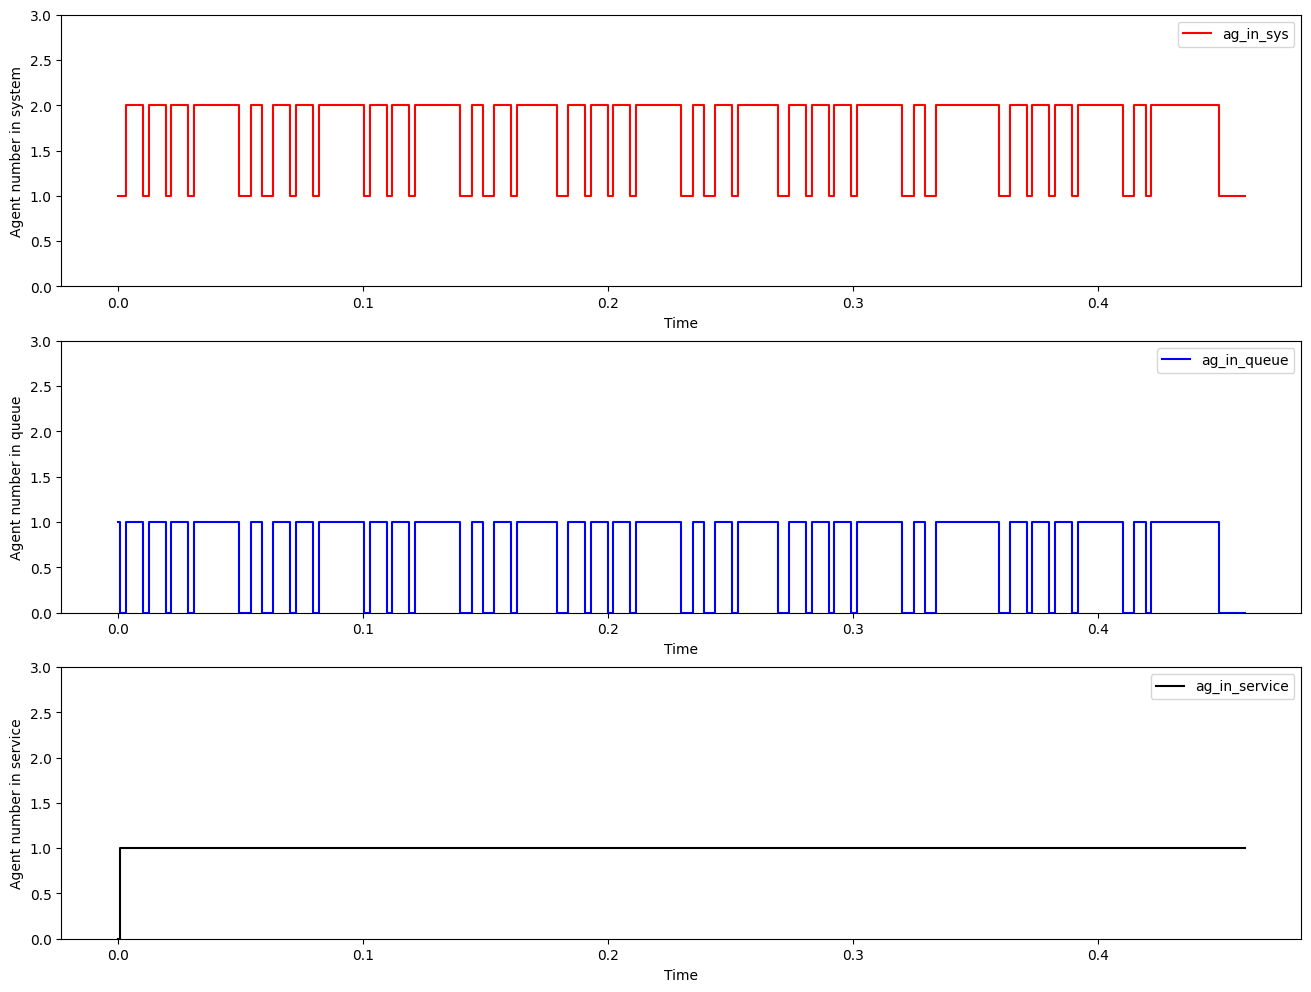

In [214]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    dd1k_counts.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(dd1k_counts['ag_in_sys']+1)])

2. Étudier le taux de refus et le taux de saturation d'une file D/D/1/K en fonction des pas des interarrivées et de ceux de service.

Le taux de blocage est donné par la valeur suivante, des tests précédents

In [218]:
dd1k_stats.loc['blocked_proportion']

run value    0.54
Name: blocked_proportion, dtype: object

Pour calculer le taux de saturation de la file, on cherche à indiquer la proportion du temps d'observation au cours duquel la file contenait le nombre maximal d'agents dans le système

In [225]:
float((dd1k_counts['ag_in_sys'] == queue_size + 1).sum() / dd1k_counts.shape[0])

0.745

3. Que pouvez-vous en dire ?

On constate par ce calcule, la différence entre les deux mesures. La saturation du système ne correspond pas au taux de blocage.

--------

# Un code plus modulable

Pour modéliser une file d'attente de manière naïve, on définit une
classe `QS` pour *Queuing System*. Deux propriétés de cet objet
modéliseront la file d'arrivées et le composant serveurs. Les temps
d'arrivées / passages des agents seront comptabilisés dans un
dataframe `tops`. Afin d'être exhaustif :

-----------

- `test_size` : taille de l'échantillon d'agents tests.

-----------

- `arval_dist` : distribution des interarrivées, sert à initialiser les
  temps d'arrivées d'un nombre défini d'agents. Il met à jour les
  arrivés `t_arval_queue` des agents.

-----------

- `srv_dist`: distribution des services, renvoie un temps de service
    depuis `t_arval_srv` d'un agent.

-----------

- `tops` : dataframe dont le schéma contient la description d'un
  agent. Il peut être enrichi par un appel à `posttreat`.

-----------

- `Wline` : encode le comportement d'une file d'attente, son comportement n'est pas synchronisé avec les temps de la file, c'est un objet qui sert plutôt comme un tag. Il porte
  les propriétés :
  - `size` : taille de la file d'attente `int`. À `None` si infinie.
  - `queue` : liste des identifiants d'agents en attente.
  - `populate` : fonction ouvrant l'accueil des agents dans la file.
  - `pop` : renvoie la tête de file, suivant la politique de priorité
    choisie. Un appel à cette fonction supprime la tête de file et
    initialise `t_arval_srv`.

-----------

- `InService` : encode le comportement de serveurs d'une file d'attente
  - `nb` : nombre de serveurs dans la file d'attente.
  - `server` : une liste d'agents en cours de se faire servir
    indexée de `0` à `nb - 1`.
  - `full` : renvoie un booléen à vrai si le serveur est plein. 
  - `leaving` : renvoie les couples index, agent quittant au plus tôt le système.

-----------

- `pretreat` : initialise `tops` avec des valeurs d'interarrivées qui suivent `arval_dist`, `tops` est trié suivant les temps d'arrivée, par construction. 

-----------

- `run` : exécution d'un batch sur la file d'attente.

-----------

- `posttreat` : consolide les statistiques d'exécution d'un run.

-----------

- `timeline` : décrit le comportement du process (nombre d'agents dans la file des arrivées / système / en service) par rapport au temps et en extrait les statistiques standards.

-----------

In [226]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        
    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None
        
        if -1 < pop_ix < len(self.queue):
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

In [227]:
line = Wline(10, (lambda x: 0))

In [228]:
line.populate([1, 2, 3, 4])

In [229]:
line.size, line.queue, line.next

(10, [1, 2, 3, 4], <function __main__.<lambda>(x)>)

In [230]:
x = line.pop()

In [231]:
x

1

In [232]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [233]:
inservice = InService(10, lambda : rng.exponential(1./3.))

In [234]:
inservice.nb, inservice.server, inservice.dist()

(10,
 [None, None, None, None, None, None, None, None, None, None],
 0.42268184344113613)

In [235]:
inservice.full()

False

In [236]:
inservice.leaving(tops)

(0, None)

In [237]:
inservice.server = [i for i in range(10)]

In [238]:
inservice.leaving(tops)

(5, np.int64(5))

# Dynamique d'exécution

1. On initialise la file d'attente avec les métadonnées la
   définissant.

2. On génère les temps d'arrivées d'un échantillon de taille définie
   dans `tops`. Les temps générés sont inclus dans
   `agent[t_arrival_queue]`.

3. On initialize `Wline` dans la mesure de sa capacité, au regard de
   l'échantillon, et par ordre des temps d'arrivées.

4. On lance une boucle :
    
    -------
    
	- On fait appel à `Wline.pop()` et on stock le résultat dans
	  `next`, si erreur on arrête le benchmark sinon, on vérifie la
      disponibilité côté serveurs, on a deux choix :

       ----

       - un serveur est disponible : on extrait sa position et

		 + on stock `next` à cette position
		 + on met à jour `next.t_arrival_srv` par
          `next.t_arrival_srv <- next.t_arrival_queue`.

       ----

	    - aucun serveur n'est disponible, on extrait le serveur contenant l'agent ayant une valeur `t_departure_sys` la plus petite, qu'on stock dans `prev`. On fait la mise à jour

	       + on pop `prev` pour l'installer dans `Log`.
	       + on fait la mise à jour `QS.t() <- prev.t_departure_sys`.
	       + on stock `next` à cette position
	       + `next.t_arrival_srv <- prev.t_departure_sys.` si `prev.t_departure_srv` est plus grande que `next.t_arrival_queue`.
	       + `next.t_arrival_srv <- next.t_arrival_queue.` sinon.

   ------

    - S'il reste des éléments dans les arrivées on va ajouter celui avec le plus petit temps d'arrivée `A` à `Wline` s'il n'est pas bloqué. Pour tester le blocage il faut comptabiliser les agents dans le système au moment de l'arrivée de `A`. Si le total est plus grand `size` `A` est bloqué, on met dans ce cas `t_depart_sys` à `-1`. Sinon on rajoute `A` à `Wline`.

In [239]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        
    def run(self):
        
        #Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        
        #Initializing arrival queue
        wline.queue = list(tops.loc[0:0].index)
        #Initializing upcomgin theoretical arrival        
        buffer_ix = 1 
    
        while buffer_ix < self.test_z:
            
            _next = wline.pop()
            if _next is not None: #Waiting line is not empty 

                #Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']
                
                #Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)
    
                #Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next 
                    
                if dept_ag is not None :
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys'] : 
                        #Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']
                        
                #Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + inservice.dist() 
                                            
            #Counting prior agents still in system
            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
                            
            if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                wline.queue.append(buffer_ix)
                    
            buffer_ix += 1
                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)

        return process, stats

In [240]:
srv_nb = 1
arval_dist = lambda size : rng.exponential(1./20, size=size)
srv_dist = lambda : rng.exponential(1./20)
queue_size = 2

In [241]:
mm1 = QS(arval_dist, srv_dist, srv_nb, queue_size=queue_size, test_size=100)

In [242]:
mm1.pretreat()

In [243]:
mm1.run()

In [244]:
mm1.posttreat()

In [245]:
mm1_bench, mm1_stats = mm1.timeline()

In [246]:
mm1_stats

,run value
mean_sojourn_time,0.087757
mean_waiting_time,0.039794
mean_service_time,0.047962
waiting_proportion,0.575
blocked_proportion,0.2
servers_max_usage,0.748744


In [247]:
import matplotlib.pyplot as plt

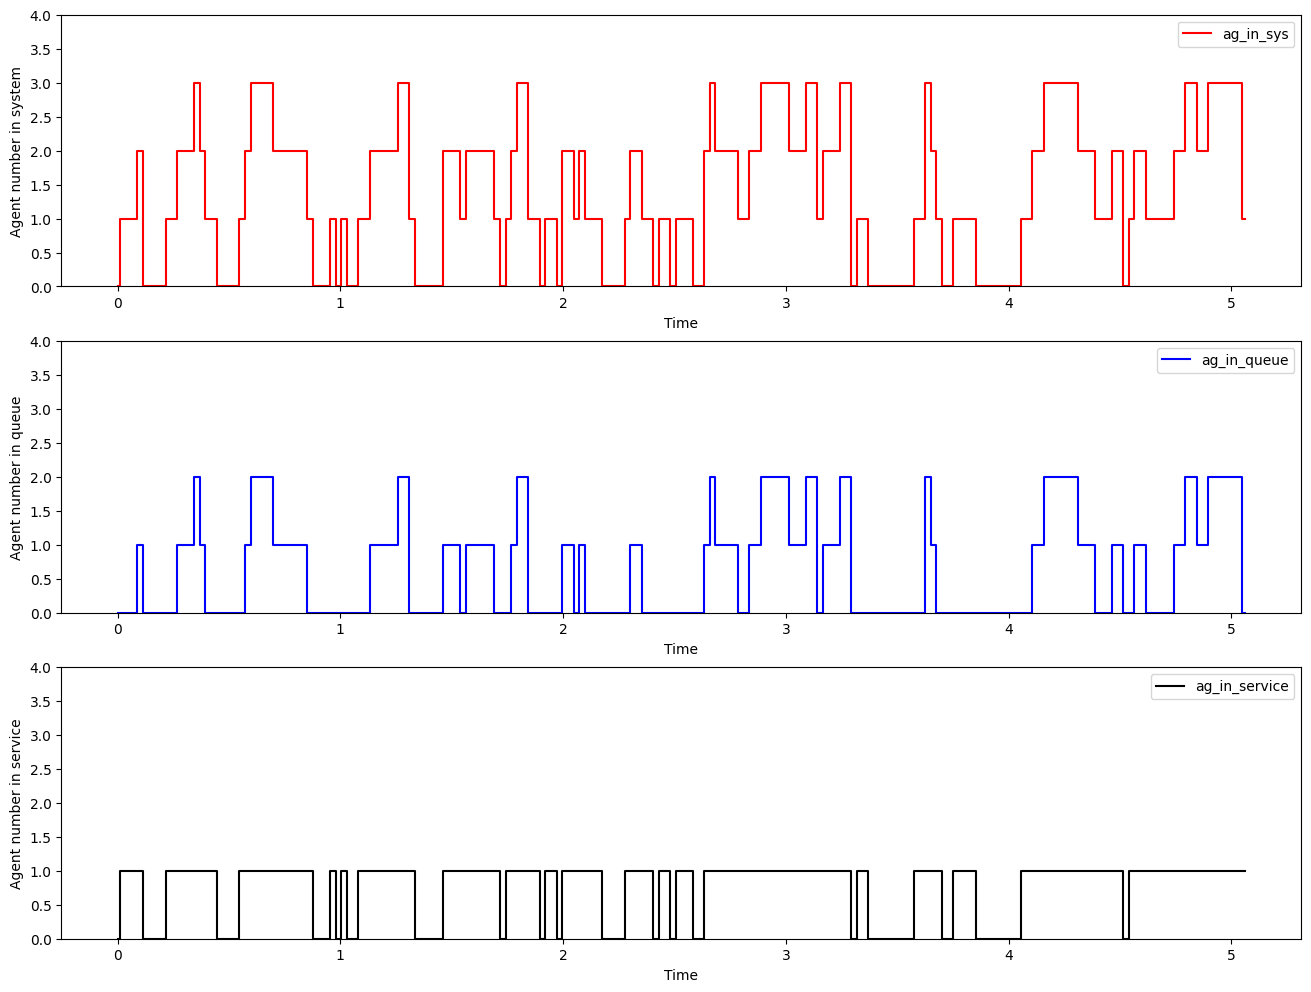

In [248]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_bench['ag_in_sys']+1)])
    